In [154]:
from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy
import pandas as pd
import json
import nltk

DATA_PATH = '../Data/'
wordnet_lemmatizer = WordNetLemmatizer()

In [195]:
# UTILITY FUNCTIONS

def save_json(save_name, dictionary):
    with open(f'{save_name}.json', 'w') as json_file:
        json.dump(dictionary, json_file, ensure_ascii=False, indent=4)
    print(f'Data has been saved to "{save_name}.json"')

def load_json(file_name):
    with open(f'{file_name}.json', 'r') as json_file:
        loaded_data = json.load(json_file)
    return loaded_data

def text_to_lowercase(dataframe):
    return dataframe['lyrics'].apply(lambda text: text.lower())

def delete_unused_text(dataframe):
    dataframe['lyrics'] = dataframe['lyrics'].replace(r'.*Lyrics\n', '', regex=True)
    dataframe['lyrics'] = dataframe['lyrics'].replace(r'\n', ' ', regex=True)
    dataframe['lyrics'] = dataframe['lyrics'].replace(r'\[.*?\]', '', regex=True)
    return dataframe['lyrics']

def remove_punctation(dataframe):
    return dataframe['lyrics'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

def tokenize(dataframe):
    return dataframe['lyrics'].apply(lambda text: nltk.word_tokenize(text))

def lemmatize_text(text):
    lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

def remove_stopwords_in_text(text):
    stopwords = (nltk.corpus.stopwords.words('english') + 
                 ['youre', 'youve', 'youll', 'youd', 'shes', 'its', 'im', 'wasnt', 'got', 'get', 'dont', 'em', 'na', 'aint', 'thats', 'cant', 'cause', 'let'])
    text_without_stopwords = [i for i in text if i not in stopwords]
    return text_without_stopwords

def remove_stopwords_from_dataframe(dataframe):
    return dataframe['lyrics'].apply(lambda text: remove_stopwords_in_text(text))

def lemmatize_df(datafarme):
    return datafarme['lyrics'].apply(lambda text: lemmatize_text(text))

In [196]:
preprocessing_pipeline = [delete_unused_text,
                          text_to_lowercase,
                          remove_punctation,
                          tokenize,
                          remove_stopwords_from_dataframe,
                          lemmatize_df]

In [197]:
east_coast = (load_json(DATA_PATH + 'east_coast'))
west_coast = (load_json(DATA_PATH + 'west_coast'))

In [198]:
east_df = pd.DataFrame(east_coast).T
west_df = pd.DataFrame(west_coast).T

In [199]:
for function in preprocessing_pipeline:
    east_df['lyrics'] = function(east_df)
    west_df['lyrics'] = function(west_df)

<h2>BOW Dictionary</h2>

In [204]:
# Utility functions for BOW
def get_tokens_as_list(dataframe):
    corpus = dataframe['lyrics'].tolist()
    corpus = [word for sublist in corpus for word in sublist]
    return corpus

def get_wordfrequencies_from_list(corpus):
    wordfrequencies = {}
    for word in corpus:
        if word not in wordfrequencies.keys():
            wordfrequencies[word] = 1
        else:
            wordfrequencies[word] += 1
    return wordfrequencies

def filter_words(list_of_tokens, dictionary):
    # Delete the tokens which is not part of the dictionary
    return [token for token in list_of_tokens if token in dictionary]

def oov_on_dataframe(dataframe, dictionary):
    return dataframe['lyrics'].apply(lambda text: filter_words(text, dictionary))

def token_counter(dataframe, column_name):
    dataframe[column_name] = dataframe['lyrics'].apply(len)
    return dataframe

# The collection of functions, this is the only one which needed to be called.
def BOW(dataframe):
    corpus = get_tokens_as_list(dataframe)
    wordfrequencies = get_wordfrequencies_from_list(corpus)
    # Sort the dictionary by frequencies
    wordfrequencies = dict(sorted(wordfrequencies.items(), key=lambda item: item[1], reverse=True))
    dataframe = token_counter(dataframe, 'token count')
    
    return dataframe, wordfrequencies

def plot_first_n_entries(bow_data, title, first_n=10):
    counter = 0
    keys = []
    counts = []
    
    for key in bow_data.keys():
        if counter == 10:
            break
        
        keys.append(key)
        counts.append(bow_data[key])
        counter += 1

    data = pd.DataFrame({'Names': keys, 'Counts': counts})
    sns.barplot(x='Names', y='Counts', data=data)
    # Customize the plot
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Counts')
    
    # Show the plot
    plt.show()    

In [205]:
east_df, bow_east = BOW(east_df)
west_df, bow_west = BOW(west_df)

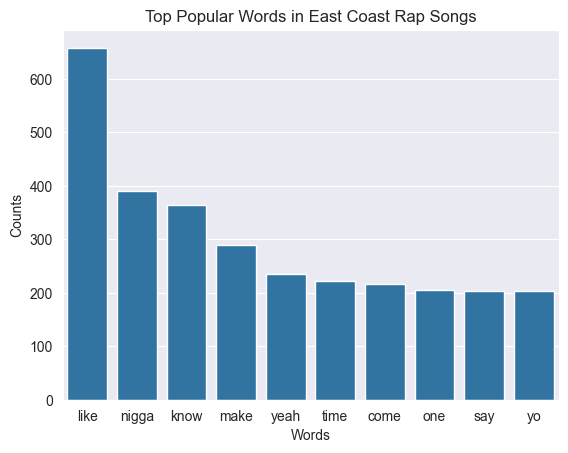

In [206]:
plot_first_n_entries(bow_east, "Top Popular Words in East Coast Rap Songs")

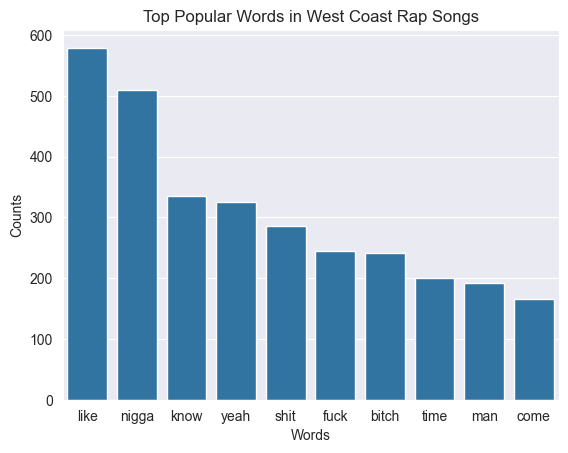

In [207]:
plot_first_n_entries(bow_west, "Top Popular Words in West Coast Rap Songs")